## GB_FX Macro Monthly

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'EUR_NOK', 'd_pi', 'Q']
Tuned params: {'n_estimators': 150, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 7.0, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.05, 'reg_alpha': 0.2, 'reg_lambda': 0.5}

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – XGB Price only with past macros) ===
Observations: 308
RMSE (level): 0.167097
MAE  (level): 0.106604
Directional accuracy: 206/307 (67.1%)

=== Diebold–Mariano vs Random Walk (XGB Price only w/ past macros, monthly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.2378
p-value     : 0.8120


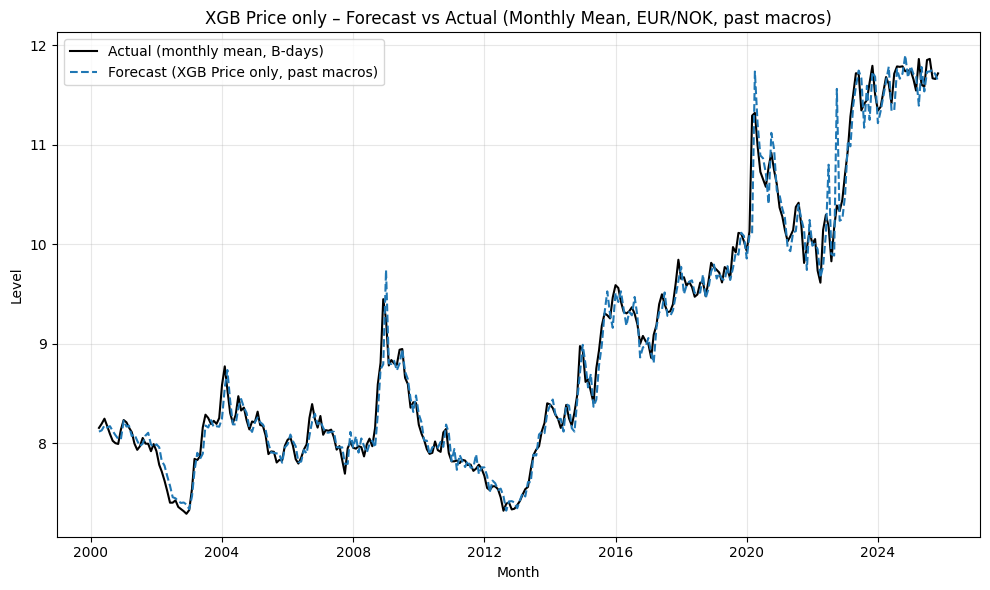

Saved PNG: XGB_PriceOnly_Monthly_PastMacroCov.png


In [1]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (monthly, levels) with daily macro covariates
# PARALLEL OUTER LOOP
#
# Univariate setup:
#   - Target: EUR_NOK (single series)
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous month (based on EUR_NOK B-days)
#   - Forecast: next calendar month at daily frequency (recursive one-step XGB),
#               aggregated to monthly mean over business days (EUR/NOK)
#   - No future macro paths used -> macros frozen at last observed value during recursion
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
#   - Constraint: n_estimators fixed at 150 (cap)
#   - History requirement MATCHES RW: min_hist_days=40 before each cut
#   - Output: save ONLY PNG as "XGB_PriceOnly_Monthly_PastMacroCov.png"
# =========================================

# If running in Colab/Jupyter, uncomment:
# !pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations

import io
import time
import math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests
import certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    max_lags: int = 20            # daily lags per variable
    max_horizon: int = 64         # guard for long months
    min_hist_days: int = 40       # minimum calendar-day history before cut (match RW)

    # === Tuned XGB hyperparameters (inner WF on FX panel) ===
    # n_estimators fixed at 150 per design constraint
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5

    tree_method: str = "hist"
    objective: str = "reg:squarederror"
    eval_metric: str = "rmse"
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    fig_png: str = "XGB_PriceOnly_Monthly_PastMacroCov.png"


CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with basic retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill (truth/aggregation base)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             on calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES, *MACRO_COLS}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Coerce to numeric, keep only valid target rows
    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day EUR_NOK series for cuts and realized monthly means
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Full calendar-day panel for XGB training/recursion
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end], based on S_b."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering (lag stack)
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, max_lags: int) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build (X, y) for one-step ahead daily prediction.

    X_t stacks lags for each variable:
      [EUR_NOK_{t-1..t-L}, Q_{t-1..t-L}, d_pi_{t-1..t-L}, dI_t_{t-1..t-L}]
    y_t = EUR_NOK_t
    """
    work = df_hist[[TARGET_SERIES] + MACRO_COLS].copy()
    lag_cols: List[str] = []

    for var in [TARGET_SERIES] + MACRO_COLS:
        for k in range(1, max_lags + 1):
            col_name = f"{var}_lag{k}"
            work[col_name] = work[var].shift(k)
            lag_cols.append(col_name)

    work = work.dropna()
    X = work[lag_cols].to_numpy()
    y = work[TARGET_SERIES].to_numpy()
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[XGBRegressor, List[str]]:
    """Fit XGB for one-step daily prediction using lagged target + lagged macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, CFG.max_lags)

    if X.shape[0] < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        min_child_weight=CFG.min_child_weight,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective=CFG.objective,
        eval_metric=CFG.eval_metric,
        tree_method=CFG.tree_method,
        random_state=CFG.random_state,
        n_jobs=1,
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    H: int
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Leakage control:
      - Macros are past-only covariates.
      - During recursion macro values are frozen at their last observed levels.
    """
    hist = df_hist_daily[[TARGET_SERIES] + MACRO_COLS].copy()
    frozen_macros = hist[MACRO_COLS].iloc[-1].to_dict()

    preds: List[float] = []

    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history to form lag features.")

        # Feature order must match make_lag_matrix: var1 lags1..L, var2 lags1..L, ...
        feat_row: List[float] = []
        for var in [TARGET_SERIES] + MACRO_COLS:
            last_vals = hist[var].iloc[-CFG.max_lags:][::-1].to_numpy()  # t-1,...,t-L
            feat_row.extend(last_vals.tolist())

        x = np.asarray(feat_row, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        # Append new predicted target + frozen macros
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        new_row = {TARGET_SERIES: yhat, **frozen_macros}
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward using XGB + past macros (parallel outer loop)
# -----------------------------
def walk_forward_xgb_monthly_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar month m:
      - Cut at last business day of previous month
      - Require at least CFG.min_hist_days daily obs before cut (match RW)
      - Fit XGB on daily history up to cut
      - Recursively forecast full next month daily
      - Aggregate to business-day monthly mean and compare to truth
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1

        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]

        # RW-matching history requirement
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # Still need enough for lagging
        if hist_df.shape[0] <= CFG.max_lags:
            return (str(m), None, "hist<=max_lags")

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")

        y_true = float(S_b.loc[idx_m_b].mean())

        # Calendar-day horizon for recursion
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df)
        pf_vals = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf_vals.values, index=f_idx, name="point")

        # Align to business days within month
        pred_b = pred_daily.reindex(idx_m_b)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")

        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(core["err"] ** 2))) if n_obs else np.nan
    mae = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = hits / total if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – XGB Price only with past macros) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else ((e_m ** 2) - (e_r ** 2))

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    # HAC extension if h>1 (not used here, but kept general)
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)  # driftless RW on monthly means
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (XGB Price only w/ past macros, monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (PNG only, no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str) -> None:
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))

    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (XGB Price only, past macros)"
    )

    plt.title("XGB Price only – Forecast vs Actual (Monthly Mean, EUR/NOK, past macros)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main
# -----------------------------
def main() -> None:
    S_b, DF_d = load_series(CFG.url)

    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")
        print(f"Tuned params: { {k: getattr(CFG, k) for k in ['n_estimators','learning_rate','max_depth','min_child_weight','subsample','colsample_bytree','gamma','reg_alpha','reg_lambda']} }")

    df_eval = walk_forward_xgb_monthly_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_monthly_simple(eval_df, CFG.fig_png)


if __name__ == "__main__":
    main()
